# Using Machine Learning methods for estimating the paramters of Heston model

In this section we try to incorporate machine learning methods to estimate paramteres of Heston pde. Furthermore, as a non-physical experimentm, we try to overlook the Heston model and implement a neural network fo rth whole task.

In [1]:
#pip install numdifftools   
# %matplotlib notebook         
%matplotlib inline        

In [2]:
#Importing essential libraries:
import csv
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sl
from scipy import stats
import numdifftools as nd
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import axes3d
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

In [3]:
"""Loading the Data"""
dir       = 'data/'
file_name = 'grid1_zheb51fo.xlsx'
UX1       = pd.read_excel(dir+file_name, sheet_name='UX1_Index')
UX2       = pd.read_excel(dir+file_name, sheet_name='UX2_Index')
UX1       = UX1.set_index('Date')
UX2       = UX2.set_index('Date')
UX1.dropna(subset = ["PX_LAST"], inplace=True)   #Getting rid of NaN values
UX2.dropna(subset = ["PX_LAST"], inplace=True)
UX1.sort_index(inplace=True)
UX2.sort_index(inplace=True)
dataset = np.array(UX1.PX_LAST)
# M = 100    #M times magnification
# dataset= dataset * M

In [4]:
"""Specifying the Input & Output (Labels)"""
n=0     #Looking at n previous days, 0 for Heston predictor
X= [[dataset[j] for j in range(i, i+n+1)] for i in range(len(dataset) - n - 1)]
Y= [dataset[i+n+1] for i in range(len(dataset) - n -1)]

In [5]:
print(dataset[:3])
print(X[:3])
print(Y[:3])

[24.85 24.45 23.55]
[[24.85], [24.45], [23.55]]
[24.45, 23.55, 23.15]


In [7]:
"""Splitting Data into Train and Test set"""
m_training= 2000
m_test= 1000

X_training_heston= X[:m_training]
Y_training_heston= Y[:m_training]   

X_test_heston= X[m_training:m_training+m_test]
Y_test_heston= Y[m_training:m_training+m_test]

if n==0:
    X_training_heston = np.ravel(X_training_heston)
    X_test_heston = np.ravel(X_test_heston)
    Y_training_heston = np.array(Y_training_heston)
    Y_test_heston = np.array(Y_test_heston)

In [8]:
"""Building the Hypothesis"""
def heston_pde_milstein(V0, k, theta, rho, sigma):
    WT  = np.sqrt( 1 ) * np.random.multivariate_normal(np.array([0, 0]), np.array([[1, rho], [rho, 1]]))[1]
    V1 = np.abs(V0+ k * (theta - V0) * 1 + sigma * np.sqrt(V0) * WT + .25 * sigma**2 * (WT**2 - 1))
    return V1

In [9]:
"""Building the Loss Function"""

#The difference between real label and the predicted one to the power of 2
#l = (heston_pde_milstein(X_training_heston[i], r, k, theta, rho, sigma) - Y_training_heston[i])**2
m=len(X_training_heston)  #Training set size
# k: x[0], theta:x[1], rho:x[2], sigma:x[3]
def Ls(X):
    def heston_inner_func(i):   #calculates the predicted lable for each training sample
        WT  = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, X[2]], [X[2], 1]]))[1]
        V1 =  np.abs(X_training_heston[i] + X[0] * (X[1] - X_training_heston[i]) * 1 + 
                     X[3] * np.sqrt(X_training_heston[i]) * WT + .25 * X[3]**2 * (WT**2 - 1))
        return V1
    Ls = (1/m) * np.sum(np.array([(heston_inner_func(i) - Y_training_heston[i])**2 for i in range(m)]))
    return Ls

In [9]:
"""ERM: Empirical Risk Minimization, Using Scipy"""

result = minimize(Ls, (0.1, 1.5, 3, 1))
print("Best Paramteres:",  result.x)
print("Minimum Ls:", result.fun)

<ipython-input-8-5cdb2417c781>:9: RuntimeWarning: covariance is not positive-semidefinite.
  WT  = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, X[2]], [X[2], 1]]))[1]
<ipython-input-8-5cdb2417c781>:9: RuntimeWarning: covariance is not positive-semidefinite.
  WT  = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, X[2]], [X[2], 1]]))[1]


Best Paramteres: [0.10000812 1.50000112 2.99999178 0.9999995 ]
Minimum Ls: 57.626286431579615


In [ ]:
"""ERM: Empirical Risk Minimization, Using Adam optimizer"""
def grad(params):
    m=len(X_training_heston)  #Training set size
    def Ls(X):
        def heston_inner_func(i):   #calculates the predicted lable for each training sample
            WT  = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, X[0]], [X[0], 1]]))[1]
            V1 =  np.abs(X_training_heston[i] + X[1] * (X[2] - X_training_heston[i]) * 1 + 
                         X[3] * np.sqrt(X_training_heston[i]) * WT + .25 * X[3]**2 * (WT**2 - 1))
            return V1
        Ls = (1/m) * np.sum(np.array([(heston_inner_func(i) - Y_training_heston[i])**2 for i in range(m)]))
        return Ls
    G = nd.Gradient(Ls)([params[0], params[1], params[2], params[3]])
    return G

def adams(grad, init, n_epochs=500, eta=10**-4, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,4])
    param_traj[0,]=init
    v=0;
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma)
        grad_sq_hat=grad_sq/(1-beta)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat+epsilon))
        param_traj[j+1,]=params
    return param_traj

Nsteps=10
lr_l=0.001
init1 = np.array([-0.7,0.5,0,1.5])
adam_trajectory1=adams(grad,init1,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)
minimum = adam_trajectory1[-1]
print(minimum)

In [ ]:
"""Qualitative Analysis of the Loss Function"""
#In this section we try to plot Loss fucntion(with reduced dimensions) to see what's going on
def Ls(X, Y, kappa, rho):
    def heston_inner_func(i):   #calculates the predicted lable for each training sample
        WT  = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, rho], [rho, 1]]))[1]
        V1 =  np.abs(X_training_heston[i] + kappa * (X - X_training_heston[i]) * 1 + 
                     Y * np.sqrt(X_training_heston[i]) * WT + .25 * Y**2 * (WT**2 - 1))
        return V1
    Ls = (1/m) * np.sum(np.array([(heston_inner_func(i) - Y_training_heston[i])**2 for i in range(m)]))
    return Ls

Z=[[] for i in range(12)]
for x in np.linspace(-4,4,8):
    for y in np.linspace(-4,4,8):
        Z[0].append(Ls(x,y,0, -0.7))
        Z[1].append(Ls(x,y,0.2,  -0.7 ))
        Z[2].append(Ls(x,y,0.7, -0.7 ))
        
        Z[3].append(Ls(x,y,0, -0.2))
        Z[4].append(Ls(x,y,0.2, -0.2))
        Z[5].append(Ls(x,y,0.7, -0.2))
        
        Z[6].append(Ls(x,y,0, 0.2))
        Z[7].append(Ls(x,y,0.2,0.2))
        Z[8].append(Ls(x,y,0.7, 0.2))
            
        Z[9].append(Ls(x,y ,0 ,0.7))
        Z[10].append(Ls(x,y,0.2 ,0.7))
        Z[11].append(Ls(x,y,0.7 ,0.7))  

In [ ]:
"""Plotting the Loss Function in 3D"""
x = np.linspace(-4,4,8)
y = np.linspace(-4,4,8)
X,Y = np.meshgrid(x,y)
X =  np.ravel(X)
Y =  np.ravel(Y)

# fig, ax1 = plt.subplots( subplot_kw={"projection": "3d"}, figsize=(10,10))
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2,2, subplot_kw={"projection": "3d"}, figsize=(15,15))
ax1.plot_trisurf(X,Y,Z[0])
ax1.plot_trisurf(X,Y,Z[1], label = "-0.5")
ax1.plot_trisurf(X,Y,Z[2], label = "0")
ax1.set_title('rho = -0.5', color ='white')
ax1.set_ylabel('Theta')
ax1.set_xlabel('Sigma')
ax1.set_zlabel('Ls')
# ax.legend(loc="best")
ax1.set_facecolor("gray")

ax2.plot_trisurf(X,Y,Z[3], label = "0.5")
ax2.plot_trisurf(X,Y,Z[4], label = "-0.5")
ax2.plot_trisurf(X,Y,Z[5], label = "0")
ax2.set_title('rho=-0.1', color ='white')
ax2.set_ylabel('Theta')
ax2.set_xlabel('Sigma')
ax2.set_zlabel('Ls')
# ax.legend(loc="best")
ax2.set_facecolor("gray")

ax3.plot_trisurf(X,Y,Z[6], label = "0.5")
ax3.plot_trisurf(X,Y,Z[7], label = "-0.5")
ax3.plot_trisurf(X,Y,Z[8], label = "0")
ax3.set_title('rho= 0', color ='white')
ax3.set_ylabel('Theta')
ax3.set_xlabel('Sigma')
ax3.set_zlabel('Ls')
# ax.legend(loc="best")
ax3.set_facecolor("gray")

ax4.plot_trisurf(X,Y,Z[9], label = "0.5")
ax4.plot_trisurf(X,Y,Z[10], label = "-0.5")
ax4.plot_trisurf(X,Y,Z[11], label = "0")
ax4.set_title('rho=0.5', color ='white')
ax4.set_xlabel('Sigma')
ax4.set_ylabel('Theta')
ax4.set_zlabel('Ls')
# ax.legend(loc="best")
ax4.set_facecolor("gray")
fig.suptitle('Heston 5-d Loss Funcion divided in 3-d seperate plots',color='white', fontsize=16)
plt.show()

In [ ]:
"""Plotting the Loss Function in 3D, Interactive Mode_1"""

# %matplotlib notebook        
# from mpl_toolkits.mplot3d import axes3d

x = np.linspace(-4,4,8)
y = np.linspace(-4,4,8)
X,Y = np.meshgrid(x,y)
X =  np.ravel(X)
Y =  np.ravel(Y)

fig, ax0 = plt.subplots( subplot_kw={"projection": "3d"}, figsize=(7,7))
ax0.plot_trisurf(X,Y,Z[7])
ax0.plot_trisurf(X,Y,Z[10], label = "-0.5")
ax0.plot_trisurf(X,Y,Z[11], label = "0")
ax0.set_title('rho=-0.7, theta = 0', color ='red')
ax0.set_xlabel('sigma')
ax0.set_ylabel('theta')
ax0.set_zlabel('Ls')
# ax.legend(loc="best")
ax0.set_facecolor("gray")

In [ ]:
"""Plotting the Loss Function in 3D, Interactive Mode_2"""

def Ls(X, Y, theta, rho):
    def heston_inner_func(i):   #calculates the predicted lable for each training sample
        WT  = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, rho], [rho, 1]]))[1]
        V1 =  np.abs(X_training_heston[i] + X * (theta - X_training_heston[i]) * 1 + 
                     Y * np.sqrt(X_training_heston[i]) * WT + .25 * Y**2 * (WT**2 - 1))
        return V1
    Ls = (1/m) * np.sum(np.array([(heston_inner_func(i) - Y_training_heston[i])**2 for i in range(m)]))
    return Ls

Z=[]
for x in np.linspace(-6,6,24):
    for y in np.linspace(-6,6,24):
        Z.append(Ls(x,y, 0, 0.5))
        
x = np.linspace(-6,6,24)
y = np.linspace(-6,6,24)
X,Y = np.meshgrid(x,y)
X =  np.ravel(X)
Y =  np.ravel(Y)

fig, ax0 = plt.subplots( subplot_kw={"projection": "3d"}, figsize=(10,10))
ax0.plot_trisurf(X,Y,Z)
ax0.set_title('rho=0.5, theta = 0', color ='white')
ax0.set_xlabel('kappa')
ax0.set_ylabel('sigma')
ax0.set_zlabel('Ls')
# ax.legend(loc="best")
ax0.set_facecolor("gray")

In [11]:
"""Best paramteres according to qualitative observatinon"""
# k, theta, rho, sigma = 0.1, 0, 0.5, 0.5
k, theta, rho, sigma = 0.1, 0, 0.5, 0.1

In [14]:
"""Evaluating the model on test Set"""
# k, theta, rho, sigma = best_params[0], best_params[1], best_params[2], best_params[3]
Y_pred = np.array([heston_pde_milstein(X_test_heston[i], k, theta, rho, sigma) for i in range(len(X_test_heston))])
Heston_ERM_pred = np.ravel(Y_pred)
#True Error
Ld =  (1/len(Y_test_heston)) * np.sum((Heston_ERM_pred - Y_test_heston)**2)
print("The True error is:", Ld)

The True error is: 7.165878315817107


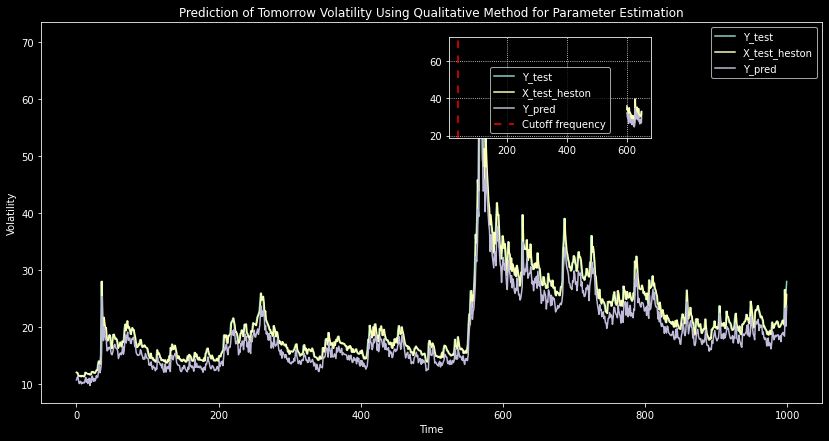

In [15]:
"""Investigating the validity of result"""
plt.style.use('dark_background')
plt.figure(figsize=(14,7))
plt.plot([t for t in range(len(Y_pred))], Y_test_heston, label = "Y_test")
plt.plot([t for t in range(len(Y_pred))], X_test_heston, label = "X_test_heston")
plt.plot([t for t in range(len(Y_pred))], Y_pred, label = "Y_pred")
plt.title("Prediction of Tomorrow Volatility Using Qualitative Method for Parameter Estimation")
# plt.axline((20,X_test_heston.mean()), (20, X_test_heston.max()), color="red", 
#            label = 'Cutoff frequency', linestyle=(0, (5, 5)))
# plt.axline((40, X_test_heston.mean()), (40,  X_test_heston.max()), 
#            color="red", label = 'Cutoff frequency', linestyle=(0, (5, 5)))
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()


a,b= 600,650
axes = plt.axes( [ 0.53, 0.65, 0.2, 0.2 ] )
axes.plot( np.arange( a , b ), Y_test_heston[a:b], label = "Y_test")
axes.plot( np.arange( a , b ), X_test_heston[a:b], label = "X_test_heston")
axes.plot( np.arange( a , b ), Y_pred[a:b], label = "Y_pred")
axes.axline((40, X_test_heston.mean()), (40,  X_test_heston.max()), 
           color="red", label = 'Cutoff frequency', linestyle=(0, (5, 5)))
axes.legend()
axes.grid( linestyle = 'dotted' )

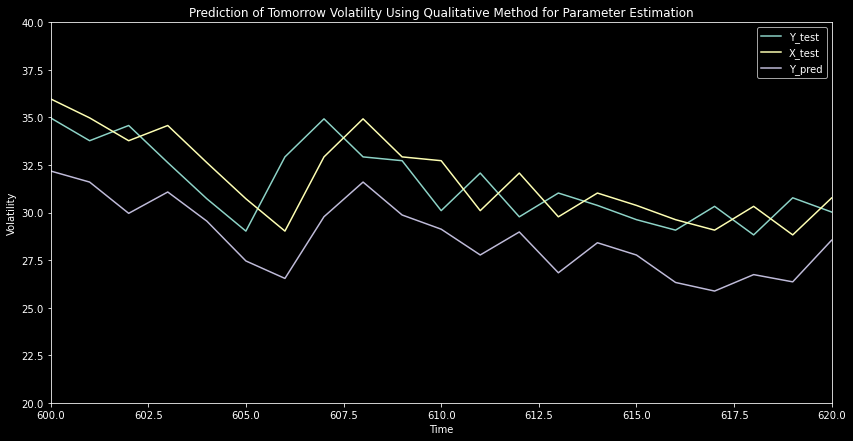

In [16]:
"""What's the probelm?"""

plt.style.use('dark_background')
plt.figure(figsize=(14,7))
plt.plot([t for t in range(len(Y_pred))], Y_test_heston, label = "Y_test")
plt.plot([t for t in range(len(Y_pred))], X_test_heston, label = "X_test")
plt.plot([t for t in range(len(Y_pred))], Y_pred, label = "Y_pred")
plt.title("Prediction of Tomorrow Volatility Using Qualitative Method for Parameter Estimation")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.xlim(600,620)
plt.ylim(20,40)
plt.legend()

## Using Neural Network for the Whole task: A Non-Physical Experiment

In [ ]:
#Let's, just for a momemnt, Ignore any pre_knowledge about the subject and see what happens
#Don't forget to run the first cell, just the first one 

n=0     #Looking at n previous days to estimate paramteres + today's volatility
X= [[dataset[j] for j in range(i, i+n+1)] for i in range(len(dataset) - n - 1)]
Y= [dataset[i+n+1] for i in range(len(dataset) - n -1)]

# Putting more emphasis on today's data:f

emphasis = 1    #repearing today's value emphasis times
for i in range(len(X)):
    for j in range(emphasis-1):
        X[i].append(X[i][-1])        

m_training= 2000
m_test= 1000

X_training_NN = X [:m_training]
Y_training_NN = Y [:m_training]   
X_test_NN     = X [m_training:m_training+m_test]
Y_test_NN     = Y [m_training:m_training+m_test]
    
#Let's scale the Volatilities:
M = 1    #M times magnification

X_training_NN  = np.array(X_training_NN)     * M
Y_training_NN  = np.array(Y_training_NN)     * M
X_test_NN      = np.array(X_test_NN)         * M
Y_test_NN      = np.array(Y_test_NN)         * M

In [34]:
NN_R = MLPRegressor(hidden_layer_sizes=(20, 20, 20), max_iter=1000, 
                    alpha=1e-4, solver='adam', momentum=0.9,
                    activation='relu', tol=1e-4, learning_rate_init=0.01)
NN_R.fit(X_training_NN, Y_training_NN)
NN_pred = NN_R.predict(X_test_NN)
# print("Predicted Volatilty:\n", Y_pred[100:120])
# print("\nTrue Volatility:\n",     Y_test[100:120])
print("\nThe score:", NN_R.score(X_test_NN, Y_test_NN))


The score: 0.9589794912186552


In [ ]:
# # Model Selection, Grid Search CV
# NN_R = MLPRegressor(max_iter=1000, alpha=1e-4, solver='adam', momentum=0.9,
#                     activation='relu', tol=1e-4, learning_rate_init=0.001)
# parameters = {'hidden_layer_sizes': [(20),(20,20),(20,20,20),(20,20,20,20),(20,20,20,20,20)]}

# gsc = GridSearchCV(NN_R, parameters, cv=5)

# gsc.fit(X_training_NN, Y_training_heston)

# print("Best parameters set found:")
# print(gsc.best_params_)
# print("\n")

# print("Score with best parameters:")
# print(gsc.best_score_)
# print("\n")

# #Correct this part
# print("All scores on the grid:")
# print(gsc.cv_results_.get('split0_test_score'))
# print(gsc.cv_results_.get('split1_test_score'))
# print(gsc.cv_results_.get('split2_test_score'))
# print(gsc.cv_results_.get('split3_test_score'))
# print(gsc.cv_results_.get('split4_test_score'))
# print(gsc.cv_results_.get('split5_test_score'))

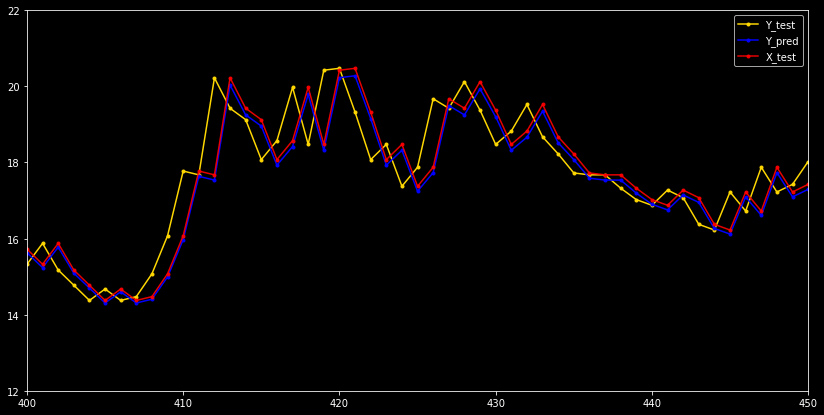

In [35]:
"""at this point we don't know if we are getting a good score just beacuse of the similarity between volatlities or
the model is working properly, we should try to figure out a way to find this!
let's plot the graphs and see what's going on"""

plt.style.use('dark_background')
plt.figure(figsize=(14,7))
plt.plot([t for t in range(len(Y_test_NN))], Y_test_NN,color='gold', marker='.', label='Y_test')
plt.plot([t for t in range(len(Y_test_NN))], NN_pred,color='b', marker='.', label='Y_pred')
plt.plot([t for t in range(len(Y_test_NN))], 
            [X_test_NN[i][-1] for i in range(len(Y_test_NN))], alpha= 0.9, color='r', marker='.', label='X_test')

plt.xlim(400,450)
plt.ylim(12,22)

plt.legend()

In [36]:
"""It seems that the result is merely a translation of today's volalitilies 
not the predictions for tomorrow!
but let's measure this preciesly"""

Distance_from_tomorrow = np.sum(np.abs(NN_pred - Y_test_NN))
Distance_from_today    = np.sum(np.abs(np.array(
                         NN_pred - [X_test_NN[i][-1] for i in range(len(list(Y_test_NN)))])))

print("Distance to Today:\n"     , np.sum(Distance_from_today))
print("\nDistance to Tommorow:\n", np.sum(Distance_from_tomorrow))

Distance to Today:
 208.9153676450919

Distance to Tommorow:
 781.6790138244603


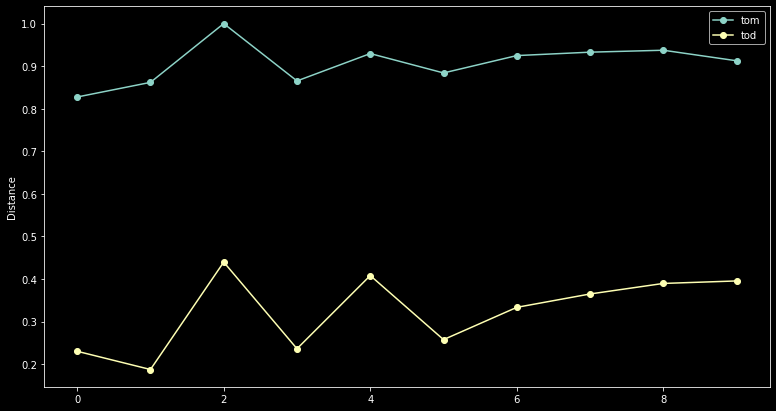

In [21]:
#Let's Investigate the behaviour of Distance w.r to n and emphasis(Looking at n previous data)
#Just Run the fist Cell before running this cell

D_today = []  #The list to save all values
D_tomorrow = []

for emphasis in [3]:
    Distance_from_today_list    = []
    Distance_from_tomorrow_list = []
    
    for n in range(0,50,5):
        X= [[dataset[j] for j in range(i, i+n+1)] for i in range(len(dataset) - n - 1)]
        Y= [dataset[i+n+1] for i in range(len(dataset) - n -1)]

        for i in range(len(X)):
            for j in range(emphasis-1):
                X[i].append(X[i][-1])    
                
        m_training = 2000
        m_test     = 1000
        X_training = X [:m_training]
        Y_training = Y [:m_training]   
        X_test     = X [m_training: m_training + m_test]
        Y_test     = Y [m_training: m_training + m_test]
                 
#         M = 10    #M times magnification
#         X_training= np.array(X_training_NN) * M
#         Y_training= np.array(Y_training_heston) * M
#         X_test= np.array(X_test) * M
#         Y_test= np.array(Y_test) * M

        NN_R.fit(X_training, Y_training)
        Y_pred = NN_R.predict(X_test)
    
        Distance_from_tomorrow    = np.sum(np.abs(Y_pred - Y_test))
        Distance_from_today = np.sum(np.abs(np.array(
                              Y_pred - [X_test[i][-1] for i in range(len(list(Y_test)))])))
        Distance_from_today_list.append(Distance_from_today)
        Distance_from_tomorrow_list.append(Distance_from_tomorrow)

    D_today.append(Distance_from_today_list)
    D_tomorrow.append(Distance_from_tomorrow_list)
    
    #Normalization:
    D_today= np.array(D_today)/(max(np.array(D_today).max(),np.array(D_tomorrow).max()))
    D_tomorrow= np.array(D_tomorrow)/(max(np.array(D_today).max(), np.array(D_tomorrow).max()))
    
    # Plotting the Result of previous part
plt.figure(figsize=(13,7))
# plt.plot([t for t in range(L)], Distance_from_today_list, )
plt.plot([t for t in range(len(D_tomorrow[0]))], D_tomorrow[0],
            marker="o", label = 'tom')
plt.plot([t for t in range(len(D_today[0]))   ],    D_today[0],
            marker="o", label = 'tod')
plt.ylabel('Distance')
plt.legend()
plt.show()

## Comparison of Ml method to MLE method:

In [22]:
#Load the MLE paramter estimatin prediction
MLE_pred = pd.read_csv('UX1_Heston_Predictions.csv').mean_sim

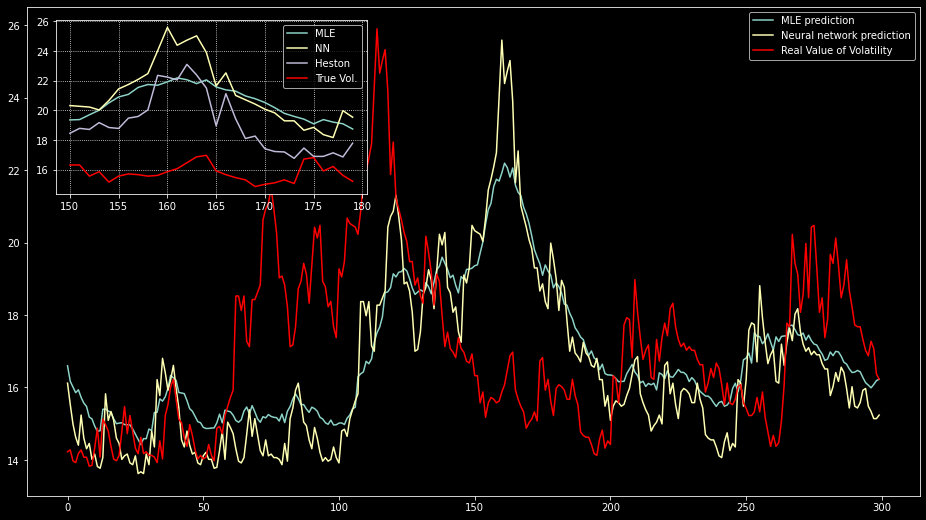

In [37]:
time_slice = 300
plt.figure(figsize=(16,9))
plt.plot([t for t in range(time_slice)], MLE_pred[2040:2040+time_slice],label= "MLE prediction")
plt.plot([t for t in range(time_slice)], NN_pred[100:100+time_slice],label="Neural network prediction")
# plt.plot([t for t in range(time_slice)], Heston_ERM_pred[100:100+time_slice],label="Heston_ERM prediction")
plt.plot([t for t in range(time_slice)], 
            Y_test[100: 100+time_slice], color ='r',
                   label= "Real Value of Volatility")
plt.legend()

a,b=150,180
axes = plt.axes( [ 0.15, 0.59, 0.27, 0.27 ] )
axes.plot( np.arange( a , b ), MLE_pred[2040+a : 2040+b] ,label = "MLE")
axes.plot( np.arange( a , b ), NN_pred[100+a : 100+b], label = "NN")
axes.plot( np.arange( a , b ), Heston_ERM_pred[100+a:100+b], label = "Heston")
axes.plot( np.arange( a , b ), Y_test[100+a:100+b], color = 'red', label = "True Vol.")
# axes.axline((40, X_test.mean()), (40,  X_test.max()), 
#            color="red", label = 'Cutoff frequency', linestyle=(0, (5, 5)))
axes.legend()
axes.grid( linestyle = 'dotted' )